In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, models
import tqdm
from google.colab import drive
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_imgs = ImageFolder('/content/drive/My Drive/Cherry_leaves_3/train',
    transform = transforms.Compose([
        transforms.RandomCrop(224),
        transforms.ToTensor()]
))

val_imgs = ImageFolder('/content/drive/My Drive/Cherry_leaves_3/val',
    transform = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor()]
))

train_loader = DataLoader(
    train_imgs, batch_size=128, shuffle=True
)
val_loader = DataLoader(
    val_imgs, batch_size=128, shuffle=False
)

In [ ]:
class FlattenLayer(nn.Module):
    def forward(self, x):
        sizes = x.size()
        return x.view(sizes[0], -1)

conv_net = nn.Sequential(
    nn.Conv2d(3, 32, 3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Dropout2d(0.25),
    nn.Conv2d(32, 64, 3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Dropout(0.25),
    FlattenLayer()
)

test_input = torch.ones(1, 3, 224, 224)
conv_output_size = conv_net(test_input).size()[-1]

mlp = nn.Sequential(
    nn.Linear(conv_output_size, 200),
    nn.ReLU(),
    nn.BatchNorm1d(200),
    nn.Dropout(0.25),
    nn.Linear(200, 2)
)

net = nn.Sequential(
    conv_net,
    mlp
)

learning_curv_y_val = []
learning_curv_y_train = []

learning_curv_x = [i for i in range(21)]

In [ ]:
def eval_net(net, data_loader, device="cpu"):
    net.eval()
    ys = []
    ypreds = []
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            _, y_pred = net(x).max(1)
        ys.append(y)
        ypreds.append(y_pred)
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)
    acc = (ys == ypreds).float().sum() / len(ys)
    return acc.item()

def train_net(net, train_loader, val_loader, optimizer_cls=optim.SGD, loss_fn=nn.CrossEntropyLoss(), n_iter=20, device="cpu"):
    train_losses = []
    train_acc = []
    val_acc = []
    optimizer = optimizer_cls(params=net.parameters(), lr=1e-3)
    
    for epoch in range(n_iter):
        running_loss = 0.0
        net.train()
        n = 0
        n_acc = 0
        for i, (xx, yy) in tqdm.tqdm(enumerate(train_loader), total=len(train_loader)):
            xx = xx.to(device)
            yy = yy.to(device)
            h = net(xx)
            loss = loss_fn(h, yy)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            n += len(xx)
            _, y_pred = h.max(1)
            n_acc += (yy == y_pred).float().sum().item()
        train_losses.append(running_loss / i)
        train_acc.append(n_acc / n)
        learning_curv_y_train.append(n_acc / n)
        learning_curv_y_val.append(eval_net(net, val_loader, device))
        val_acc.append(eval_net(net, val_loader, device))
        print(epoch, train_losses[-1], train_acc[-1], val_acc[-1], flush=True)

In [ ]:
net.to("cuda:0")
learning_curv_y_train.append(eval_net(net, train_loader, device="cuda:0"))
learning_curv_y_val.append(eval_net(net, val_loader, device="cuda:0"))
train_net(net, train_loader, val_loader, n_iter=20, device="cuda:0")

100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


0 0.2615315755829215 0.887434554973822 0.5


100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


1 0.09985926607623696 0.9781849912739965 0.5


100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


2 0.08100843569263816 0.9799301919720768 0.5027778148651123


100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


3 0.0910414841491729 0.9781849912739965 0.5472222566604614


100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


4 0.06366766430437565 0.9860383944153578 0.6888889074325562


100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


5 0.06324726482853293 0.9886561954624782 0.8222222328186035


100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


6 0.06310672126710415 0.9860383944153578 0.9222222566604614


100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


7 0.05023896670900285 0.9895287958115183 0.9611111283302307


100%|██████████| 9/9 [00:06<00:00,  1.29it/s]


8 0.059652336640283465 0.987783595113438 0.9777777791023254


100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


9 0.047245465917512774 0.9886561954624782 0.9861111640930176


100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


10 0.0532064416911453 0.987783595113438 0.9916666746139526


100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


11 0.047793333302251995 0.987783595113438 0.9944444894790649


100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


12 0.03460488247219473 0.9965095986038395 0.9944444894790649


100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


13 0.038090382469817996 0.9947643979057592 0.9944444894790649


100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


14 0.036712151719257236 0.9930191972076788 0.9944444894790649


100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


15 0.037792266346514225 0.9930191972076788 0.9944444894790649


100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


16 0.033575969049707055 0.993891797556719 0.9944444894790649


100%|██████████| 9/9 [00:07<00:00,  1.28it/s]


17 0.033716001780703664 0.9921465968586387 0.9944444894790649


100%|██████████| 9/9 [00:07<00:00,  1.28it/s]


18 0.03505426994524896 0.9904013961605584 0.9944444894790649


100%|██████████| 9/9 [00:07<00:00,  1.28it/s]


19 0.03364858380518854 0.9930191972076788 0.9972222447395325


In [ ]:
model_save_name = 'filename.pth' 
path = "/content/drive/My Drive/iGEM/Cherry_CNN_3" 
torch.save(net.state_dict(), path) 

In [ ]:
test_imgs = ImageFolder('/content/drive/My Drive/Cherry_leaves_3/test',
    transform = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor()]
))

test_loader = DataLoader(
    test_imgs, batch_size=128, shuffle=True
)

print(eval_net(net, test_loader, device="cuda:0"))

0.9925000071525574


Text(0.5, 1.0, 'learning curve')

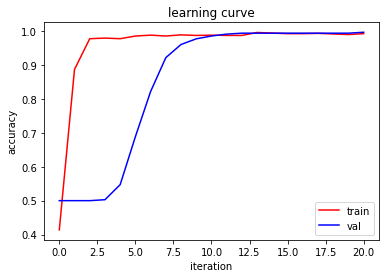

In [ ]:
plt.plot(learning_curv_x, learning_curv_y_train, label = "train", color = "red")

plt.plot(learning_curv_x, learning_curv_y_val, label = "val", color = "blue")
plt.legend()
plt.xlabel("iteration")
plt.ylabel("accuracy")
plt.title("learning curve")